In [2]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV                                         # to split the data
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, r2_score, accuracy_score, confusion_matrix, classification_report, fbeta_score     # to evaluate our model
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

import joblib
import pickle
import json

import missingno as msno
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


ModuleNotFoundError: No module named 'xgboost'

In [1]:
#data import
df = pd.read_csv("../data/triage.csv",sep=';',encoding='latin-1')

NameError: name 'pd' is not defined

In [253]:
#null check
df.isnull().values.any()

True

In [254]:
## data processing
def missing_values_table(dataframe):
    variables_with_na = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[variables_with_na].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[variables_with_na].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df)
    return variables_with_na

df['NRS_pain'] = df[["NRS_pain"]].replace("#BOÞ!",np.NaN)

missing_values_table(df)

                 n_miss  ratio
Saturation          688 54.300
NRS_pain            556 43.880
Diagnosis in ED       2  0.160


['NRS_pain', 'Saturation', 'Diagnosis in ED']

In [255]:
df = df.dropna()

In [256]:
df.isnull().values.any()

False

<AxesSubplot:>

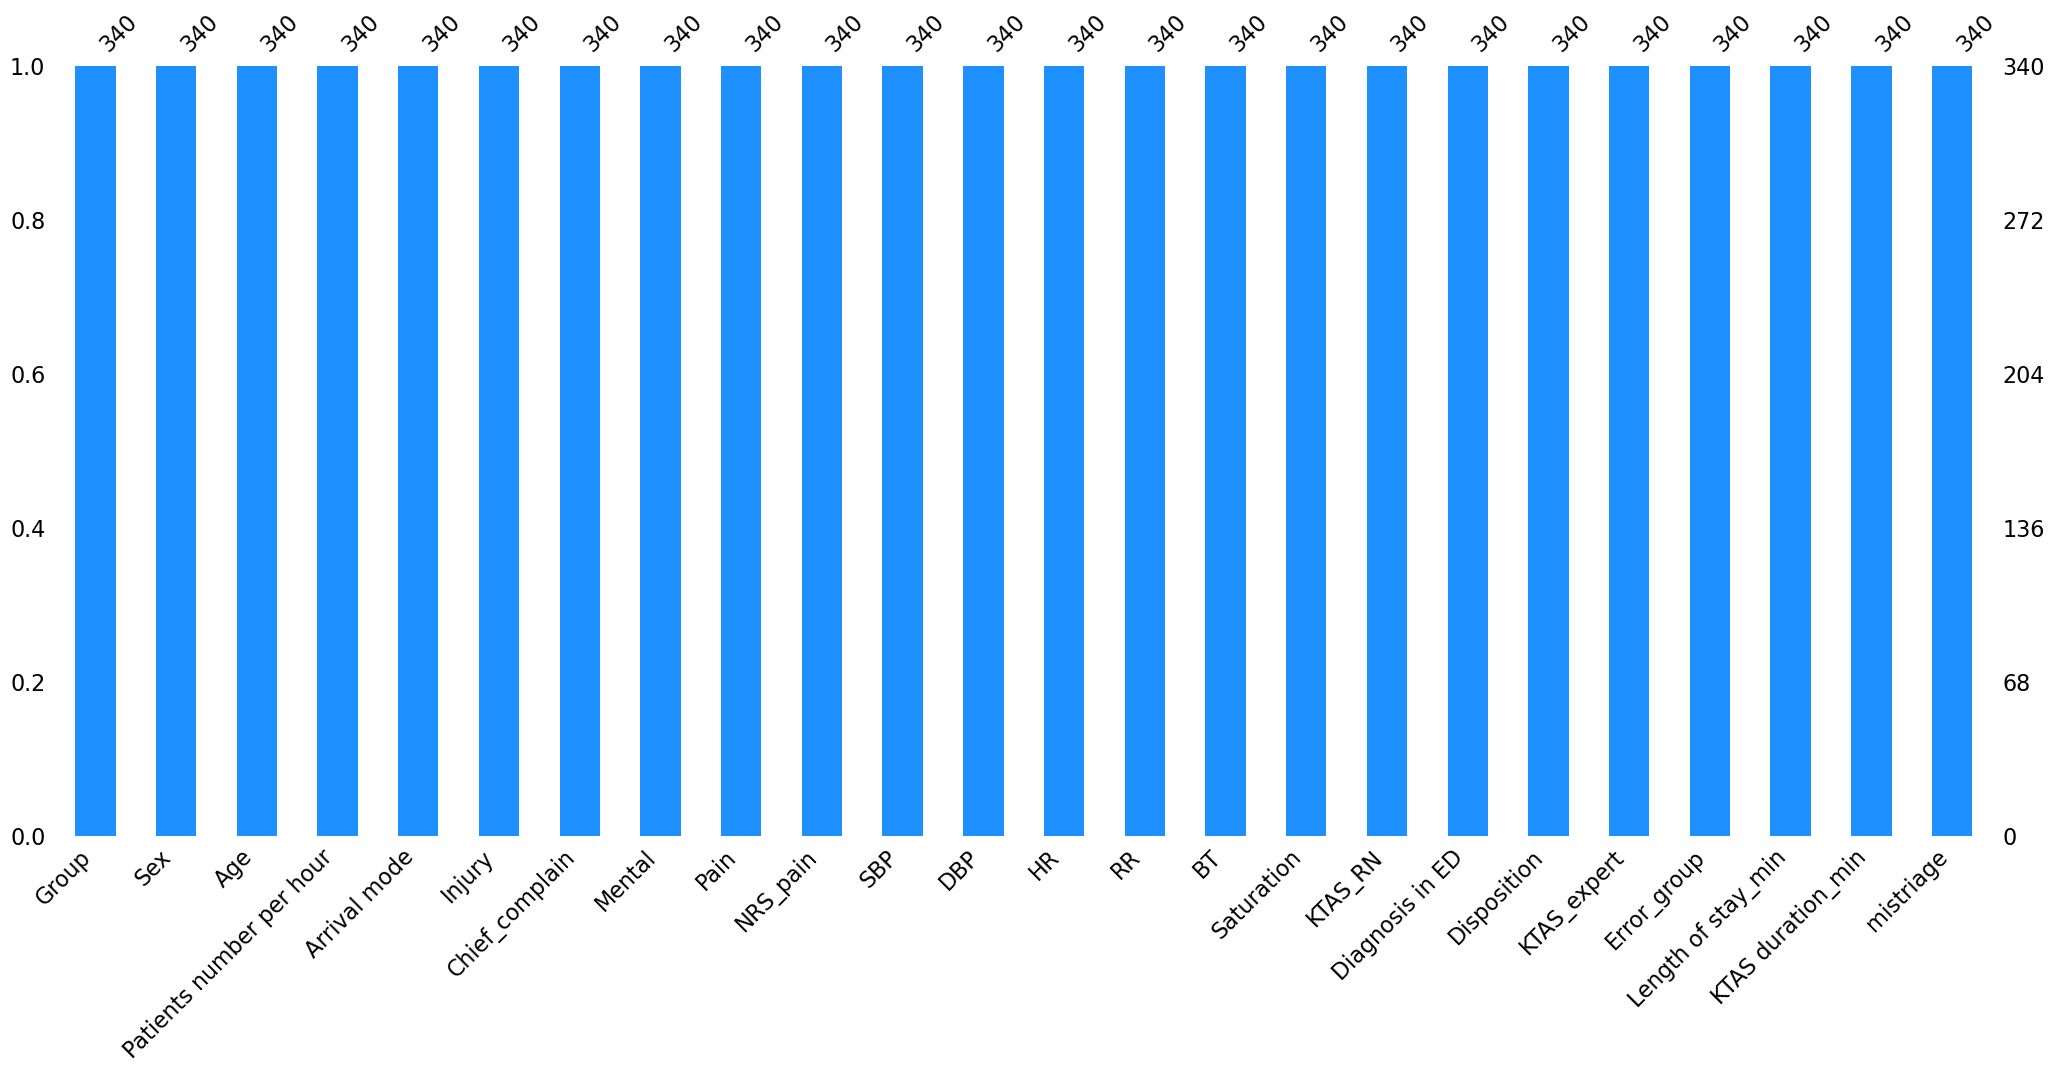

In [257]:
msno.bar(df, color="dodgerblue")

In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340 entries, 0 to 1245
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Group                     340 non-null    int64 
 1   Sex                       340 non-null    int64 
 2   Age                       340 non-null    int64 
 3   Patients number per hour  340 non-null    int64 
 4   Arrival mode              340 non-null    int64 
 5   Injury                    340 non-null    int64 
 6   Chief_complain            340 non-null    object
 7   Mental                    340 non-null    int64 
 8   Pain                      340 non-null    int64 
 9   NRS_pain                  340 non-null    object
 10  SBP                       340 non-null    object
 11  DBP                       340 non-null    object
 12  HR                        340 non-null    object
 13  RR                        340 non-null    object
 14  BT                       

In [259]:
df["Pain"].unique()

array([1], dtype=int64)

In [260]:
injury_cat = ['No','Yes']
sex_cat = ['Female','Male']
pain_cat = ['No','Yes']
mental_cat = ['Alert','Verbose Response','Pain Response','Unresponsive']
disposition_cat = ['Discharge', 'Admission to Ward', 'Admission to ICU', 'Discharge', 'Transfer', 'Death', 'Surgery']
KTAS_cat = ['Emergency','Emergency','Emergency', 'Non-Emergency', 'Non-Emergency']
error_cat = ['Vital sign','Physical exam','Psychatric','Pain','Mental','Underlying-disease','Medical-records-of-other-ED','On-set','Others']
df['NRS_pain'] = df['NRS_pain'].apply(lambda x:int(x))


###############################################################################################################################
#Categorical data were entered as numerical data. Therefore, it was categorized again categorically to make it more meaningful. 
###############################################################################################################################
df.loc[df["Sex"] == 1, "Sex"] = sex_cat[0]
df.loc[df["Sex"] == 2, "Sex"] = sex_cat[1]

df.loc[df["Injury"] == 1, "Injury"] = injury_cat[0]
df.loc[df["Injury"] == 2, "Injury"] = injury_cat[1]

df.loc[df["Pain"] == 0, "Pain"] = pain_cat[0]
df.loc[df["Pain"] == 1, "Pain"] = pain_cat[1]

df.loc[df["Mental"] == 1, "Mental"] = mental_cat[0]
df.loc[df["Mental"] == 2, "Mental"] = mental_cat[1]
df.loc[df["Mental"] == 3, "Mental"] = mental_cat[2]
df.loc[df["Mental"] == 4, "Mental"] = mental_cat[3]

df.loc[df["Disposition"] == 1, "Disposition"] = disposition_cat[0]
df.loc[df["Disposition"] == 2, "Disposition"] = disposition_cat[1]
df.loc[df["Disposition"] == 3, "Disposition"] = disposition_cat[2]
df.loc[df["Disposition"] == 4, "Disposition"] = disposition_cat[3]
df.loc[df["Disposition"] == 5, "Disposition"] = disposition_cat[4]
df.loc[df["Disposition"] == 6, "Disposition"] = disposition_cat[5]
df.loc[df["Disposition"] == 7, "Disposition"] = disposition_cat[6]

df.loc[df["KTAS_expert"] == 1, "KTAS_expert"] = KTAS_cat[0]
df.loc[df["KTAS_expert"] == 2, "KTAS_expert"] = KTAS_cat[1]
df.loc[df["KTAS_expert"] == 3, "KTAS_expert"] = KTAS_cat[2]
df.loc[df["KTAS_expert"] == 4, "KTAS_expert"] = KTAS_cat[3]
df.loc[df["KTAS_expert"] == 5, "KTAS_expert"] = KTAS_cat[4]

df.loc[df["Error_group"] == 1, "Error_group"] = error_cat[0]
df.loc[df["Error_group"] == 2, "Error_group"] = error_cat[1]
df.loc[df["Error_group"] == 3, "Error_group"] = error_cat[2]
df.loc[df["Error_group"] == 4, "Error_group"] = error_cat[3]
df.loc[df["Error_group"] == 5, "Error_group"] = error_cat[4]
df.loc[df["Error_group"] == 6, "Error_group"] = error_cat[5]
df.loc[df["Error_group"] == 7, "Error_group"] = error_cat[6]
df.loc[df["Error_group"] == 8, "Error_group"] = error_cat[7]
df.loc[df["Error_group"] == 9, "Error_group"] = error_cat[8]
###############################################################################################################################
##############               Nonsense data was encountered in variables containing numerical data.                 ############
##############                 These values have been replaced by the mode of the variable.                        ############
###############################################################################################################################

df[["SBP","DBP","HR","RR","BT","Saturation"]] = df[["SBP","DBP","HR","RR","BT","Saturation"]].replace("??",0).astype(str).astype(float)
df['SBP'] = df['SBP'].replace(0,df['SBP'].mode()[0])
df['DBP'] = df['DBP'].replace(0,df['DBP'].mode()[0])

###############################################################################################################################
##############                                        Feature Engineering                                          ############
###############################################################################################################################
interval = (0, 25, 45, 60, 100)
cats = ['Young', 'Adult', 'Mid_Age', 'Old']
df["New_Age"] = pd.cut(df.Age, interval, labels=cats)

df.loc[df['SBP'] < 80, 'New_SBP'] = 'Low'
df.loc[(df["SBP"] >= 80) & (df["SBP"] <= 120), 'New_SBP'] = 'Normal'
df.loc[df['SBP'] > 120, 'New_SBP'] = 'High'

df.loc[df['DBP'] < 60, 'New_DBP'] = 'Low'
df.loc[(df["DBP"] >= 60) & (df["DBP"] <= 80), 'New_DBP'] = 'Normal'
df.loc[df['DBP'] > 80, 'New_DBP'] = 'High'

df.loc[df['HR'] < 45, 'New_HR'] = 'Low'
df.loc[(df["HR"] >= 45) & (df["HR"] <= 100), 'New_HR'] = 'Normal'
df.loc[df['HR'] > 100, 'New_HR'] = 'High'

df.loc[df['RR'] < 12, 'New_RR'] = 'Low'
df.loc[(df["RR"] >= 12) & (df["RR"] <= 25), 'New_RR'] = 'Normal'
df.loc[df['RR'] > 25, 'New_RR'] = 'High'

df.loc[df['BT'] < 36.4, 'New_BT'] = 'Low'
df.loc[(df["BT"] >= 36.4) & (df["BT"] <= 37.6), 'New_BT'] = 'Normal'
df.loc[df['BT'] > 37.6, 'New_BT'] = 'High'

df.loc[df['Saturation'] < 80, 'New_Saturation'] = 'Extreme'
df.loc[df['Saturation'] > 95 & (df["Saturation"] <= 80 ), 'New_Saturation'] = 'Low'
df.loc[(df["Saturation"] >= 95) & (df["Saturation"] <= 100), 'New_Saturation'] = 'Normal'
df.loc[df['Saturation'] > 100, 'New_Saturation'] = 'High'

df.loc[df['NRS_pain'] < 3, 'New_NRS_pain'] = 'Low Pain'
df.loc[(df["NRS_pain"] >= 3) & (df["NRS_pain"] <= 7), 'New_NRS_pain'] = 'Pain'
df.loc[df['NRS_pain'] > 7, 'New_NRS_pain'] = 'High Pain'

df.loc[df['Length of stay_min'] < 10, 'New_Length_of_stay_min'] = '10min_less'
df.loc[(df["Length of stay_min"] >= 10) & (df["Length of stay_min"] <= 60), 'New_Length_of_stay_min'] = '10-60_min'
df.loc[(df["Length of stay_min"] >= 61) & (df["Length of stay_min"] <= 120), 'New_Length_of_stay_min'] = '60-120_min'
df.loc[(df["Length of stay_min"] >= 121) & (df["Length of stay_min"] <= 240), 'New_Length_of_stay_min'] = '120-240_min'
df.loc[df['Length of stay_min'] > 240, 'New_Length_of_stay_min'] = '240_min_plus'

df.head()

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage,New_Age,New_SBP,New_DBP,New_HR,New_RR,New_BT,New_Saturation,New_NRS_pain,New_Length_of_stay_min
0,2,Male,71,3,3,Yes,right ocular pain,Alert,Yes,2,160.000,100.000,84.000,18.000,36.600,100.000,2,Corneal abrasion,Discharge,Non-Emergency,Physical exam,86,"5,00",1,Old,High,High,Normal,Normal,Normal,Normal,Low Pain,60-120_min
2,2,Female,68,8,2,Yes,"arm pain, Lt",Alert,Yes,2,130.000,80.000,102.000,20.000,36.600,98.000,4,"Fracture of surgical neck of humerus, closed",Admission to Ward,Non-Emergency,Pain,862,"1,00",1,Old,High,Normal,High,Normal,Normal,Normal,Low Pain,240_min_plus
5,2,Female,54,6,4,No,fever,Alert,Yes,3,140.000,90.000,94.000,20.000,38.100,98.000,3,"Fever, unspecified",Admission to Ward,Non-Emergency,Vital sign,9246,"2,00",1,Mid_Age,High,High,Normal,Normal,High,Normal,Pain,240_min_plus
6,2,Male,49,11,3,No,With chest discomfort,Alert,Yes,3,110.000,70.000,70.000,20.000,36.200,98.000,2,"Angina pectoris, unspecified",Discharge,Emergency,Physical exam,400,"3,00",1,Mid_Age,Normal,Normal,Normal,Normal,Low,Normal,Pain,240_min_plus
9,2,Female,38,6,3,No,"Eczema, Eyelid",Alert,Yes,3,130.000,80.000,80.000,20.000,36.300,97.000,4,Ocular pain,Discharge,Non-Emergency,Pain,185,"4,00",1,Adult,High,Normal,Normal,Normal,Low,Normal,Pain,120-240_min


In [265]:
def one_hot_encoder(dataframe, categorical_columns, nan_as_category=False):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_columns,
                               dummy_na=nan_as_category, drop_first=False)
    new_columns = [col for col in dataframe.columns if col not in original_columns]
    return dataframe, new_columns

def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.05)
    quartile3 = variable.quantile(0.95)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)

# predict triage

In [266]:
new_df = df[["Sex","Injury", "Mental","Pain","New_Saturation", "KTAS_expert", "Error_group", "New_Age", "New_SBP", "New_DBP", "New_HR","New_RR", "New_BT", "New_NRS_pain"]]

In [267]:
like_num = [col for col in new_df.columns if new_df[col].dtypes != 'O' and len(new_df[col].value_counts()) > 10]
cols_need_scale = [col for col in new_df.columns if col not in like_num
                   and col not in 'KTAS_expert']

In [268]:
for col in like_num:
    new_df[col] = robust_scaler(new_df[col])

new_df, one_hot_encodeds = one_hot_encoder(new_df, cols_need_scale)

In [269]:
new_df.head()

,KTAS_expert,Sex_Female,Sex_Male,Injury_No,Injury_Yes,Mental_Alert,Mental_Unresponsive,Mental_Verbose Response,Pain_Yes,New_Saturation_Extreme,New_Saturation_Low,New_Saturation_Normal,Error_group_0,Error_group_Medical-records-of-other-ED,Error_group_On-set,Error_group_Others,Error_group_Pain,Error_group_Physical exam,Error_group_Psychatric,Error_group_Vital sign,New_Age_Young,New_Age_Adult,New_Age_Mid_Age,New_Age_Old,New_SBP_High,New_SBP_Normal,New_DBP_High,New_DBP_Low,New_DBP_Normal,New_HR_High,New_HR_Low,New_HR_Normal,New_RR_High,New_RR_Low,New_RR_Normal,New_BT_High,New_BT_Low,New_BT_Normal,New_NRS_pain_High Pain,New_NRS_pain_Low Pain,New_NRS_pain_Pain
0,Non-Emergency,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0
2,Non-Emergency,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0
5,Non-Emergency,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1
6,Emergency,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
9,Non-Emergency,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1


In [270]:
X = new_df.drop(['KTAS_expert','Sex_Female','Injury_No','Error_group_0'],axis=1)
y = np.ravel(new_df[['KTAS_expert']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 357)

In [271]:
# Let's set the parameters to find the best parameter to use in our models. These parameters will be chosen as the best to visit with GridSearchCV.
rf_params = {"max_depth": [3, 5, 8],
             "max_features": [8, 15, 25],
             "n_estimators": [200, 500, 1000],
             "min_samples_split": [2, 5, 10]}

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [200, 500, 1000],
               "max_depth": [3, 5, 8],
               "colsample_bytree": [1, 0.8, 0.5]}

#xgb_params = {"learning_rate": [0.1, 0.01],
#              "max_depth": [3, 5, 8],
#              "n_estimators": [200, 500, 1000],
#              "colsample_bytree": [0.7, 1]}

rf = RandomForestClassifier(random_state=357)
lgbm = LGBMClassifier(random_state=357)
#xgb = XGBClassifier(random_state=357)

# Let's try the parameters one by one with the help of GridSearchCV and find the best parameter.
gs_cv_rf = GridSearchCV(rf, rf_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)
gs_cv_lgbm = GridSearchCV(lgbm, lgbm_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)
#gs_cv_xgb = GridSearchCV(xgb, xgb_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [272]:
#lgr_tuned = LogisticRegression(random_state=357).fit(X_train, y_train)
knn_tuned = KNeighborsClassifier().fit(X_train, y_train)
svm_tuned = SVC(random_state=357,gamma='auto').fit(X_train, y_train)
gnb_tuned = GaussianNB().fit(X_train, y_train)
dtc_tuned = DecisionTreeClassifier(random_state=357).fit(X_train, y_train)

# Let's tune the models with the best parameters found.
rf_tuned = RandomForestClassifier(**gs_cv_rf.best_params_, random_state=357).fit(X_train, y_train)
lgbm_tuned = LGBMClassifier(**gs_cv_lgbm.best_params_, random_state=357).fit(X_train, y_train)
#xgb_tuned = XGBClassifier(**gs_cv_xgb.best_params_, random_state=357).fit(X_train, y_train)

In [273]:
# Result
models = [#("LGR", lgr_tuned),
          ("KNN", knn_tuned),
          ("SVM", svm_tuned),
          ("GNB", gnb_tuned),
          ("DTC", dtc_tuned),
          ("RF", rf_tuned),
          ("LGBM", lgbm_tuned),
          #("XGB", xgb_tuned)
         ]

for name, model in models:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    msg = "%s: (%f)" % (name, acc)
    print(msg)

KNN: (0.485294)
SVM: (0.705882)
GNB: (0.367647)
DTC: (0.573529)
RF: (0.705882)
LGBM: (0.705882)


In [340]:
#joblib.dump(svm_tuned,r"./triage.pkl")
with open('../server/artifacts/triage.pkl','wb') as f:
    pickle.dump(svm_tuned,f)

In [327]:
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("../server/artifacts/columns.json","w") as f:
    f.write(json.dumps(columns))

In [274]:
X_test.head()

,Sex_Male,Injury_Yes,Mental_Alert,Mental_Unresponsive,Mental_Verbose Response,Pain_Yes,New_Saturation_Extreme,New_Saturation_Low,New_Saturation_Normal,Error_group_Medical-records-of-other-ED,Error_group_On-set,Error_group_Others,Error_group_Pain,Error_group_Physical exam,Error_group_Psychatric,Error_group_Vital sign,New_Age_Young,New_Age_Adult,New_Age_Mid_Age,New_Age_Old,New_SBP_High,New_SBP_Normal,New_DBP_High,New_DBP_Low,New_DBP_Normal,New_HR_High,New_HR_Low,New_HR_Normal,New_RR_High,New_RR_Low,New_RR_Normal,New_BT_High,New_BT_Low,New_BT_Normal,New_NRS_pain_High Pain,New_NRS_pain_Low Pain,New_NRS_pain_Pain
106,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
700,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1
610,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
408,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
12,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1


In [275]:
np.where(X.columns=='Injury_Yes')[0][0]

1

In [320]:
def predict__Triage(Sexm,Injuryy,Mental,Painy,New_Saturation,Error_group,New_Age,New_SBP,New_DBP,New_HR,New_RR,New_BT,New_NRS_pain):
    Mental_index = np.where(X.columns==Mental)[0][0]
    New_Saturation_index = np.where(X.columns==New_Saturation)[0][0]
    Error_group_index = np.where(X.columns==Error_group)[0][0]
    New_Age_index = np.where(X.columns==New_Age)[0][0]
    New_SBP_index = np.where(X.columns==New_SBP)[0][0]
    New_DBP_index = np.where(X.columns==New_DBP)[0][0]
    New_HR_index = np.where(X.columns==New_HR)[0][0]
    New_RR_index = np.where(X.columns==New_RR)[0][0]
    New_BT_index = np.where(X.columns==New_BT)[0][0]
    New_NRS_pain_index = np.where(X.columns==New_NRS_pain)[0][0]
  
    x = np.zeros(len(X.columns))
    x[0] = Sexm
    x[1] = Injuryy
    x[5] = Painy
    
    if Mental_index >= 0:
        x[Mental_index] = 1
    if New_Saturation_index >= 0:
        x[New_Saturation_index] = 1
    if Error_group_index >= 0:
        x[Error_group_index] = 1
    if New_Age_index >= 0:
        x[New_Age_index] = 1
    if New_SBP_index >= 0:
        x[New_SBP_index] = 1
    if New_DBP_index >= 0:
        x[New_DBP_index] = 1
    if New_HR_index >= 0:
        x[New_HR_index] = 1
    if New_RR_index >= 0:
        x[New_RR_index] = 1
    if New_BT_index >= 0:
        x[New_BT_index] = 1
    if New_NRS_pain_index >= 0:
        x[New_NRS_pain_index] = 1

    return svm_tuned.predict([x])[0]

In [321]:
predict__Triage(1,1,'Mental_Alert',1,'New_Saturation_Low','Error_group_Others','New_Age_Young','New_SBP_Normal','New_DBP_Normal','New_HR_Normal','New_RR_Normal','New_BT_Low','New_NRS_pain_Low Pain')

'Non-Emergency'

In [322]:
predict__Triage(1,1,'Mental_Alert',1,'New_Saturation_Low','Error_group_Pain','New_Age_Young','New_SBP_High','New_DBP_High','New_HR_Low','New_RR_High','New_BT_High','New_NRS_pain_Pain')

'Emergency'

# Predict Diposition

In [279]:
new_df1 = df[["Sex","Injury", "Mental","Pain","New_Saturation","Disposition", "KTAS_expert", "Error_group", "New_Age", "New_SBP", "New_DBP", "New_HR","New_RR", "New_BT", "New_NRS_pain"]]

In [280]:
like_num = [col for col in new_df1.columns if new_df1[col].dtypes != 'O' and len(new_df1[col].value_counts()) > 10]
cols_need_scale = [col for col in new_df1.columns if col not in like_num
                   and col not in 'Disposition']

In [281]:
for col in like_num:
    new_df1[col] = robust_scaler(new_df1[col])

new_df1, one_hot_encodeds = one_hot_encoder(new_df1, cols_need_scale)

In [282]:
X1 = new_df1.drop(['Disposition','Sex_Female','Injury_No','Error_group_0'],axis=1)
y1 = np.ravel(new_df1[['Disposition']])

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.20, random_state = 357)

In [283]:
# Let's set the parameters to find the best parameter to use in our models. These parameters will be chosen as the best to visit with GridSearchCV.
rf_params = {"max_depth": [3, 5, 8],
             "max_features": [8, 15, 25],
             "n_estimators": [200, 500, 1000],
             "min_samples_split": [2, 5, 10]}

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [200, 500, 1000],
               "max_depth": [3, 5, 8],
               "colsample_bytree": [1, 0.8, 0.5]}

#xgb_params = {"learning_rate": [0.1, 0.01],
#              "max_depth": [3, 5, 8],
#              "n_estimators": [200, 500, 1000],
#              "colsample_bytree": [0.7, 1]}

rf = RandomForestClassifier(random_state=357)
lgbm = LGBMClassifier(random_state=357)
#xgb = XGBClassifier(random_state=357)

# Let's try the parameters one by one with the help of GridSearchCV and find the best parameter.
gs_cv_rf = GridSearchCV(rf, rf_params, cv=10, n_jobs=-1, verbose=2).fit(X_train1, y_train1)
gs_cv_lgbm = GridSearchCV(lgbm, lgbm_params, cv=10, n_jobs=-1, verbose=2).fit(X_train1, y_train1)
#gs_cv_xgb = GridSearchCV(xgb, xgb_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [284]:
#lgr_tuned = LogisticRegression(random_state=357).fit(X_train, y_train)
knn_tuned1 = KNeighborsClassifier().fit(X_train1, y_train1)
svm_tuned1 = SVC(random_state=357,gamma='auto').fit(X_train1, y_train1)
gnb_tuned1 = GaussianNB().fit(X_train1, y_train1)
dtc_tuned1 = DecisionTreeClassifier(random_state=357).fit(X_train1, y_train1)

# Let's tune the models with the best parameters found.
rf_tuned1 = RandomForestClassifier(**gs_cv_rf.best_params_, random_state=357).fit(X_train1, y_train1)
lgbm_tuned1 = LGBMClassifier(**gs_cv_lgbm.best_params_, random_state=357).fit(X_train1, y_train1)
#xgb_tuned = XGBClassifier(**gs_cv_xgb.best_params_, random_state=357).fit(X_train, y_train)

In [285]:
# Result
models = [#("LGR", lgr_tuned),
          ("KNN", knn_tuned1),
          ("SVM", svm_tuned1),
          ("GNB", gnb_tuned1),
          ("DTC", dtc_tuned1),
          ("RF", rf_tuned1),
          ("LGBM", lgbm_tuned1),
          #("XGB", xgb_tuned)
         ]

for name, model in models:
    y_pred1 = model.predict(X_test1)
    acc = accuracy_score(y_test1, y_pred1)
    msg = "%s: (%f)" % (name, acc)
    print(msg)

KNN: (0.573529)
SVM: (0.588235)
GNB: (0.147059)
DTC: (0.558824)
RF: (0.720588)
LGBM: (0.705882)


In [341]:
with open('../server/artifacts/Diposition.pkl','wb') as f:
    pickle.dump(rf_tuned1,f)

In [329]:
columns1 = {
    'data_columns' : [col.lower() for col in X1.columns]
}
with open("../server/artifacts/columns1.json","w") as f:
    f.write(json.dumps(columns1))

In [286]:
X_test1.head()

,Sex_Male,Injury_Yes,Mental_Alert,Mental_Unresponsive,Mental_Verbose Response,Pain_Yes,New_Saturation_Extreme,New_Saturation_Low,New_Saturation_Normal,KTAS_expert_Emergency,KTAS_expert_Non-Emergency,Error_group_Medical-records-of-other-ED,Error_group_On-set,Error_group_Others,Error_group_Pain,Error_group_Physical exam,Error_group_Psychatric,Error_group_Vital sign,New_Age_Young,New_Age_Adult,New_Age_Mid_Age,New_Age_Old,New_SBP_High,New_SBP_Normal,New_DBP_High,New_DBP_Low,New_DBP_Normal,New_HR_High,New_HR_Low,New_HR_Normal,New_RR_High,New_RR_Low,New_RR_Normal,New_BT_High,New_BT_Low,New_BT_Normal,New_NRS_pain_High Pain,New_NRS_pain_Low Pain,New_NRS_pain_Pain
106,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
700,1,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1
610,1,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
408,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
12,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1


In [287]:
def predict_Diposition_expert(Sexm,Injuryy,Mental,Painy,New_Saturation,KTAS_expert,Error_group,New_Age,New_SBP,New_DBP,New_HR,New_RR,New_BT,New_NRS_pain):
    Mental_index = np.where(X1.columns==Mental)[0][0]
    New_Saturation_index = np.where(X1.columns==New_Saturation)[0][0]
    KTAS_expert_index = np.where(X1.columns==KTAS_expert)[0][0]
    Error_group_index = np.where(X1.columns==Error_group)[0][0]
    New_Age_index = np.where(X1.columns==New_Age)[0][0]
    New_SBP_index = np.where(X1.columns==New_SBP)[0][0]
    New_DBP_index = np.where(X1.columns==New_DBP)[0][0]
    New_HR_index = np.where(X1.columns==New_HR)[0][0]
    New_RR_index = np.where(X1.columns==New_RR)[0][0]
    New_BT_index = np.where(X1.columns==New_BT)[0][0]
    New_NRS_pain_index = np.where(X1.columns==New_NRS_pain)[0][0]
  
    x = np.zeros(len(X1.columns))
    x[0] = Sexm
    x[1] = Injuryy
    x[5] = Painy
    
    if Mental_index >= 0:
        x[Mental_index] = 1
    if New_Saturation_index >= 0:
        x[New_Saturation_index] = 1
    if KTAS_expert_index >= 0:
        x[KTAS_expert_index] = 1
    if Error_group_index >= 0:
        x[Error_group_index] = 1
    if New_Age_index >= 0:
        x[New_Age_index] = 1
    if New_SBP_index >= 0:
        x[New_SBP_index] = 1
    if New_DBP_index >= 0:
        x[New_DBP_index] = 1
    if New_HR_index >= 0:
        x[New_HR_index] = 1
    if New_RR_index >= 0:
        x[New_RR_index] = 1
    if New_BT_index >= 0:
        x[New_BT_index] = 1
    if New_NRS_pain_index >= 0:
        x[New_NRS_pain_index] = 1

    return rf_tuned1.predict([x])[0]

In [288]:
predict_Diposition_expert(1,1,'Mental_Alert',1,'New_Saturation_Low','KTAS_expert_Emergency','Error_group_Others','New_Age_Young','New_SBP_Normal','New_DBP_Normal','New_HR_Normal','New_RR_Normal','New_BT_Low','New_NRS_pain_Low Pain')

'Admission to Ward'

In [289]:
predict_Diposition_expert(1,1,'Mental_Alert',1,'New_Saturation_Low','KTAS_expert_Emergency','Error_group_Pain','New_Age_Young','New_SBP_High','New_DBP_High','New_HR_Low','New_RR_High','New_BT_High','New_NRS_pain_Pain')

'Discharge'

# predict New_Length_of_stay_min

In [290]:
new_df2 = df[["Sex","Injury", "Mental","Pain","New_Saturation","Disposition", "KTAS_expert", "Error_group", "New_Age", "New_SBP", "New_DBP", "New_HR","New_RR", "New_BT", "New_NRS_pain","New_Length_of_stay_min"]]

In [291]:
like_num = [col for col in new_df2.columns if new_df2[col].dtypes != 'O' and len(new_df2[col].value_counts()) > 10]
cols_need_scale = [col for col in new_df2.columns if col not in like_num
                   and col not in 'New_Length_of_stay_min']

In [292]:
for col in like_num:
    new_df2[col] = robust_scaler(new_df2[col])

new_df2, one_hot_encodeds = one_hot_encoder(new_df2, cols_need_scale)

In [293]:
X2 = new_df2.drop(['New_Length_of_stay_min','Sex_Female','Injury_No','Error_group_0'],axis=1)
y2 = np.ravel(new_df2[['New_Length_of_stay_min']])

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state = 357)

In [294]:
# Let's set the parameters to find the best parameter to use in our models. These parameters will be chosen as the best to visit with GridSearchCV.
rf_params = {"max_depth": [3, 5, 8],
             "max_features": [8, 15, 25],
             "n_estimators": [200, 500, 1000],
             "min_samples_split": [2, 5, 10]}

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [200, 500, 1000],
               "max_depth": [3, 5, 8],
               "colsample_bytree": [1, 0.8, 0.5]}

#xgb_params = {"learning_rate": [0.1, 0.01],
#              "max_depth": [3, 5, 8],
#              "n_estimators": [200, 500, 1000],
#              "colsample_bytree": [0.7, 1]}

rf = RandomForestClassifier(random_state=357)
lgbm = LGBMClassifier(random_state=357)
#xgb = XGBClassifier(random_state=357)

# Let's try the parameters one by one with the help of GridSearchCV and find the best parameter.
gs_cv_rf = GridSearchCV(rf, rf_params, cv=10, n_jobs=-1, verbose=2).fit(X_train2, y_train2)
gs_cv_lgbm = GridSearchCV(lgbm, lgbm_params, cv=10, n_jobs=-1, verbose=2).fit(X_train2, y_train2)
#gs_cv_xgb = GridSearchCV(xgb, xgb_params, cv=10, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [295]:
#lgr_tuned = LogisticRegression(random_state=357).fit(X_train, y_train)
knn_tuned2 = KNeighborsClassifier().fit(X_train2, y_train2)
svm_tuned2 = SVC(random_state=357,gamma='auto').fit(X_train2, y_train2)
gnb_tuned2 = GaussianNB().fit(X_train2, y_train2)
dtc_tuned2 = DecisionTreeClassifier(random_state=357).fit(X_train2, y_train2)

# Let's tune the models with the best parameters found.
rf_tuned2 = RandomForestClassifier(**gs_cv_rf.best_params_, random_state=357).fit(X_train2, y_train2)
lgbm_tuned2 = LGBMClassifier(**gs_cv_lgbm.best_params_, random_state=357).fit(X_train2, y_train2)
#xgb_tuned = XGBClassifier(**gs_cv_xgb.best_params_, random_state=357).fit(X_train, y_train)

In [296]:
# Result
models = [#("LGR", lgr_tuned),
          ("KNN", knn_tuned2),
          ("SVM", svm_tuned2),
          ("GNB", gnb_tuned2),
          ("DTC", dtc_tuned2),
          ("RF", rf_tuned2),
          ("LGBM", lgbm_tuned2),
          #("XGB", xgb_tuned)
         ]

for name, model in models:
    y_pred2 = model.predict(X_test2)
    acc = accuracy_score(y_test2, y_pred2)
    msg = "%s: (%f)" % (name, acc)
    print(msg)

KNN: (0.823529)
SVM: (0.867647)
GNB: (0.044118)
DTC: (0.691176)
RF: (0.823529)
LGBM: (0.852941)


In [342]:
#joblib.dump(rf_tuned1,r"./New_Length_of_stay_min.pkl")
with open('../server/artifacts/New_Length_of_stay_min.pkl','wb') as f:
    pickle.dump(svm_tuned2,f)

In [346]:
columns2 = {
    'data_columns' : [col.lower() for col in X2.columns]
}
with open("../server/artifacts/columns2.json","w") as f:
    f.write(json.dumps(columns2))

In [297]:
X_test2.head()

,Sex_Male,Injury_Yes,Mental_Alert,Mental_Unresponsive,Mental_Verbose Response,Pain_Yes,New_Saturation_Extreme,New_Saturation_Low,New_Saturation_Normal,Disposition_Admission to Ward,Disposition_Death,Disposition_Discharge,Disposition_Surgery,Disposition_Transfer,KTAS_expert_Emergency,KTAS_expert_Non-Emergency,Error_group_Medical-records-of-other-ED,Error_group_On-set,Error_group_Others,Error_group_Pain,Error_group_Physical exam,Error_group_Psychatric,Error_group_Vital sign,New_Age_Young,New_Age_Adult,New_Age_Mid_Age,New_Age_Old,New_SBP_High,New_SBP_Normal,New_DBP_High,New_DBP_Low,New_DBP_Normal,New_HR_High,New_HR_Low,New_HR_Normal,New_RR_High,New_RR_Low,New_RR_Normal,New_BT_High,New_BT_Low,New_BT_Normal,New_NRS_pain_High Pain,New_NRS_pain_Low Pain,New_NRS_pain_Pain
106,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
700,1,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1
610,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
408,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
12,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1


In [343]:
def predict_New_Length_of_stay_min_expert(Sexm,Injuryy,Mental,Painy,New_Saturation,Disposition,KTAS_expert,Error_group,New_Age,New_SBP,New_DBP,New_HR,New_RR,New_BT,New_NRS_pain):
    Mental_index = np.where(X2.columns==Mental)[0][0]
    New_Saturation_index = np.where(X2.columns==New_Saturation)[0][0]
    Disposition_index = np.where(X2.columns==Disposition)[0][0]
    KTAS_expert_index = np.where(X2.columns==KTAS_expert)[0][0]
    Error_group_index = np.where(X2.columns==Error_group)[0][0]
    New_Age_index = np.where(X2.columns==New_Age)[0][0]
    New_SBP_index = np.where(X2.columns==New_SBP)[0][0]
    New_DBP_index = np.where(X2.columns==New_DBP)[0][0]
    New_HR_index = np.where(X2.columns==New_HR)[0][0]
    New_RR_index = np.where(X2.columns==New_RR)[0][0]
    New_BT_index = np.where(X2.columns==New_BT)[0][0]
    New_NRS_pain_index = np.where(X2.columns==New_NRS_pain)[0][0]
  
    x = np.zeros(len(X2.columns))
    x[0] = Sexm
    x[1] = Injuryy
    x[5] = Painy
    
    if Mental_index >= 0:
        x[Mental_index] = 1
    if New_Saturation_index >= 0:
        x[New_Saturation_index] = 1
    if Disposition_index >= 0:
        x[Disposition_index] = 1
    if KTAS_expert_index >= 0:
        x[KTAS_expert_index] = 1
    if Error_group_index >= 0:
        x[Error_group_index] = 1
    if New_Age_index >= 0:
        x[New_Age_index] = 1
    if New_SBP_index >= 0:
        x[New_SBP_index] = 1
    if New_DBP_index >= 0:
        x[New_DBP_index] = 1
    if New_HR_index >= 0:
        x[New_HR_index] = 1
    if New_RR_index >= 0:
        x[New_RR_index] = 1
    if New_BT_index >= 0:
        x[New_BT_index] = 1
    if New_NRS_pain_index >= 0:
        x[New_NRS_pain_index] = 1

    return svm_tuned2.predict([x])[0]

In [344]:
predict_New_Length_of_stay_min_expert(1,1,'Mental_Alert',1,'New_Saturation_Low','Disposition_Admission to Ward','KTAS_expert_Non-Emergency','Error_group_Pain','New_Age_Young','New_SBP_High','New_DBP_High','New_HR_Low','New_RR_High','New_BT_High','New_NRS_pain_Pain')

'240_min_plus'

In [345]:
predict_New_Length_of_stay_min_expert(1,1,'Mental_Alert',1,'New_Saturation_Low','Disposition_Discharge','KTAS_expert_Emergency','Error_group_Pain','New_Age_Young','New_SBP_High','New_DBP_High','New_HR_Low','New_RR_High','New_BT_High','New_NRS_pain_Pain')

'240_min_plus'